In [3]:
%matplotlib inline
import scipy
import sympy
from modsim import *
import numpy as np
# Average statistics.
# Grams of ethanol consumed.
alcohol_consumed = 15
# Absorption rate constant. 3.18 is mean blood value.
k = 3.18
# BAC. .04 is the legal driving limit, though you should never drink and drive!
BAC = .04 
# Elimination rate constant. .163 is mean blood value.
beta = .163
# Body fat ratio. .67 for women, .73 men.
ratio = .73
# Weight.
weight = 70
# Liters of blood in human body
blood_amount = 5
#


class simplistic_model():
    """
    One-compartment model for alcohol absorption and elimination.
    """
    def __init__(self):
        """
        Constructor.
        """
        pass
    @staticmethod   
    def absorb_alcohol(d, t, w=weight):
        """
        Returns the amount of alcohol absorbed.
        """
        return ((d * (1-np.exp(-k*t)))/(ratio*w))
    
    @staticmethod   
    def eliminate_alcohol(t):
        """
        Returns the amount of alcohol eliminated
        """
        return beta * t

    @staticmethod   
    def model_alcohol_processing(d, t):
        """
        Simulates alcohol processing with a timeseries.
        TODO this is currently untested but pushing anyways.
        h = number of hours.
        d = dosage in grams of ethanol.
        """
        result = TimeSeries()
        for h in linrange(0, t):
            result[h] = (simplistic_model.absorb_alcohol(d, (h)) - simplistic_model.eliminate_alcohol((h)))/blood_amount
            if result[h] <= 0:
                result[h] = 0
        return result
    
    @staticmethod
    def model_processing_after_eating(d, t, time_of_eating, initial_weight, weight_gain, time_of_eating_2, weight_gain_2, food_2 = None):
        """
        Simulates alcohol processing and factors in weight gain as well.
        d = dosage in hours
        If food_2 is None, then simulation will run from 0 to time_of_eating to t. Else, it should run from 0 to time_of_eating to time_of_eating_2 to t
        """
        

        if food_2 is None:
            result = TimeSeries()
            for i in linrange(0, time_of_eating):
                result[i] = (simplistic_model.absorb_alcohol(d, (i), initial_weight) - simplistic_model.eliminate_alcohol((i)))/blood_amount
                if result[i] <= 0:
                    result[i] = 0
            for j in linrange(time_of_eating, t):
                result[j] = (simplistic_model.absorb_alcohol(d, (j), (initial_weight + weight_gain)) - simplistic_model.eliminate_alcohol((j)))/blood_amount
                if result[j] <= 0:
                    result[j] = 0
            return result
        else:
            result = TimeSeries()
            for i in linrange(0, time_of_eating):
                result[i] = (simplistic_model.absorb_alcohol(d, (i), initial_weight) - simplistic_model.eliminate_alcohol((i)))/blood_amount
                if result[i] <= 0:
                    result[i] = 0
            for j in linrange(time_of_eating, time_of_eating_2):
                result[j] = (simplistic_model.absorb_alcohol(d, (j), (initial_weight + weight_gain)) - simplistic_model.eliminate_alcohol((j)))/blood_amount
                if result[j] <= 0:
                    result[j] = 0
            for h in linrange(time_of_eating_2, t):
                result[h] = (simplistic_model.absorb_alcohol(d, (h), (initial_weight + weight_gain + weight_gain_2)) - simplistic_model.eliminate_alcohol((h)))/blood_amount
                if result[h] <= 0:
                    result[h] = 0
            return result
        
    @staticmethod   
    def weight_based_on_bac(t, input_BAC):
        """
        Returns the weight of the individual based on static BAC and time.
        """
        return (alcohol_consumed*(1-np.exp(-k*t)))/((input_BAC + beta*t)*ratio)
    
    @staticmethod   
    def BAC_based_on_weight(t, input_weight):
        """
        Returns the BAC of the individual based on static weight and time.
        """
    
        return ((alcohol_consumed*(1-np.exp(-k*t))/(ratio*input_weight)) - beta*t)
        

class three_compartment_model():
    """
    Three-compartment model for alcohol absorption and
    """
    def __init__(self, y1, k=-5.07):
        """
        Constructor.
        """
        self.k = k
        self.i_c = y1
        self.y1 = y1
        self.y2 = 0
        self.y3 = 0
        self.results = TimeSeries()
        
    def model_alcohol_processing(self, t):
        """
        Model alcohol processing in the body. For each time, run stomach, small intestine, and large intestine processing
        """
        results = TimeSeries()
        for a in linrange(0, t):
            a1 = self.stomach_processing()
            a2 = self.small_intestine_processing()
            a3 = self.lean_body_processing()
            results[a] = (a1 + a2 + a3)/(a + 1)
            if a == 0:
                results[a] = 0
            if results[a] == 0:
                results[a] = 0
        return results
    
    def stomach_processing(self):
        """
        Models alcohol processing in the stomach.
        """
        self.y1 = (abs((self.stomach_processing_slope(self.y1))))/blood_amount
        if self.y1 < 0:
            self.y1 = 0
        return self.y1
    
    def small_intestine_processing(self):
        self.y2 = abs((((three_compartment_model.small_intestine_slope(self.y1, self.y2)))))/blood_amount
        if self.y2 < 0:
            self.y2 = 0
        return self.y2
    
    def lean_body_processing(self):
        self.y3 = abs(((three_compartment_model.lean_body_slope(self.y2, self.y3))))/blood_amount
        return self.y3
        
    @staticmethod
    def lean_body_slope(y2, y3):
        return -7.50*y2 - ((.470*y3)/(.380 + y3))

    @staticmethod
    def gastric_emptying(d, t):
        """
        Models alcohol processing in the stomach.
        """
        return ((-7.05)/((1 + (.42*(d/.470)**2)*t)))
    
    def stomach_processing_slope(self, c):
        return ((self.k*c)/(1.00 + (0.42*c)**2))

    @staticmethod
    def small_intestine_slope(y1, y2):
        return ((5.07*y1)/(1.00 + (0.42*y1)**2)) - 7.05*y2

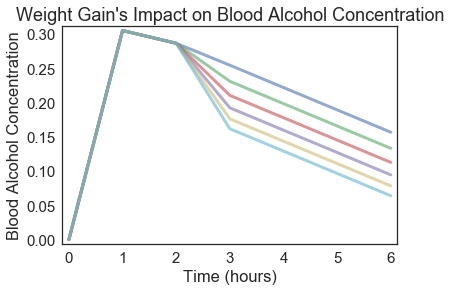

In [4]:
weight_gainz = linrange(0, 25, 5) # Utsav added step of 5 to linrage to make graph cleaner
for gainz in weight_gainz:
    plot(simplistic_model.model_processing_after_eating(90, 6, 3, 70, gainz, 4, 50, None))
title("Weight Gain's Impact on Blood Alcohol Concentration")
xlabel("Time (hours)")
ylabel("Blood Alcohol Concentration")

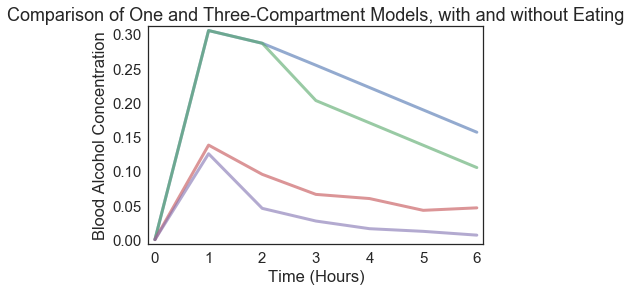

In [3]:
plot(simplistic_model.model_alcohol_processing(90, 6), label="One-compartment model, without eating")
plot(simplistic_model.model_processing_after_eating(90, 6, 3, 70, 12, 4, 50, None), label="One-compartment model, eating at three hour mark")
three1 = three_compartment_model(.12)
plot(three1.model_alcohol_processing(6))
three2 = three_compartment_model(.12,-4.00)
plot(three2.model_alcohol_processing(6))
xlabel("Time (Hours)")
ylabel("Blood Alcohol Concentration")
title("Comparison of One and Three-Compartment Models, with and without Eating")
